In [0]:
%pip
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.functions import vector_to_array
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
import warnings
warnings.filterwarnings("ignore")

#1.1 Import the monthly and annual data and join

#####Import the monthly and annual data

In [0]:
annual_feature = spark.read.format("csv").option("header", 
                                      "true").load("dbfs:/FileStore/tables/annual_features.csv")
annual_day_of_week_counts_pivot = spark.read.format("csv").option("header","true").load("dbfs:/FileStore/tables/annual_day_of_week_counts_pivot.csv")
days_since_last_txn = spark.read.format("csv").option("header",
                                      "true").load("dbfs:/FileStore/tables/days_since_last_txn.csv")
mth_day_counts = spark.read.format("csv").option("header", 
                                      "true").load("dbfs:/FileStore/tables/mth_day_counts.csv")
mth_rolling_features = spark.read.format("csv").option("header","true").load("dbfs:/FileStore/tables/mth_rolling_features.csv")
retail_data_response = spark.read.format("csv").option("header",
                                      "true").load("dbfs:/FileStore/tables/Retail_Data_Response.csv")

#####Join the annual data

In [0]:
annual_features = annual_feature.join(annual_day_of_week_counts_pivot,on = "customer_id",how = "left")
annual_features = annual_features.join(retail_data_response,on = "customer_id", how = "left")
annual_features = annual_features.dropna()

#####Join the monthly data

In [0]:
mth_features = mth_rolling_features.join(mth_day_counts,on=["CLNT_NO","ME_DT"],how="left")
mth_features = mth_features.join(days_since_last_txn,on=["CLNT_NO","ME_DT"],how="left")
mth_features = mth_features.join(retail_data_response, mth_features["CLNT_NO"]==retail_data_response["customer_id"],how="left")
mth_features = mth_features.drop("customer_id")
mth_features = mth_features.dropna()

#1.2 Steps for each method

#####Pre-process the data : Cast feature type to Double

#####Fit the training dataset and optimize the hyperparameters of the method.

#####Plot probability distribution for test set

In [0]:
lr = LogisticRegression(featuresCol = "scaled_features", labelCol = 'response', maxIter=10, elasticNetParam=1)

 
paramGrid_lr = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.01, 0.1, 0.0])# regularization parameter
                .build())
 
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid_lr, 
                    evaluator=BinaryClassificationEvaluator(labelCol="response"), numFolds=5, seed=1147)
 
cvModel_lr = cv_lr.fit(scaledTrain_annual)

predTrain_lr=cvModel_lr.transform(scaledTrain_annual)
predTest_lr=cvModel_lr.transform(scaledTest_annual)
bestModel_lr=cvModel_lr.bestModel
print('Best Param (regParam):', bestModel_lr._java_obj.getRegParam())

Best Param (regParam): 0.01


#####Pre-process the data : Vectorize and Standardize

#####Plot probability distribution for test set

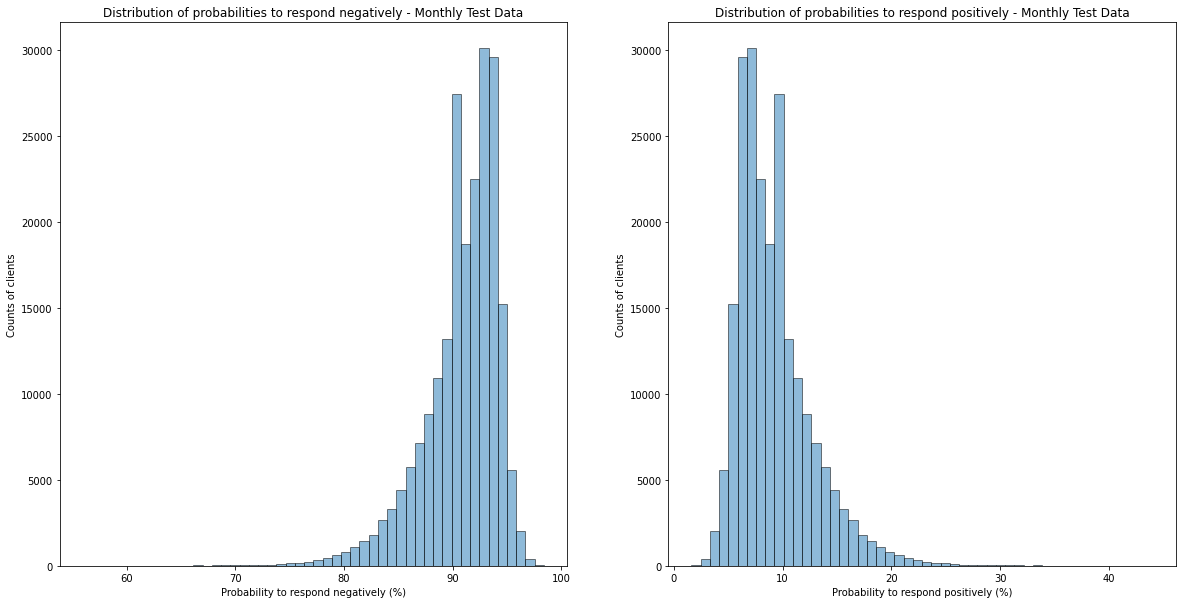

In [0]:
mth_probTest_lr = mth_predTest_lr.select("probability")
mth_probTest_lr_list = list(mth_probTest_lr.select('probability').toPandas()['probability'])
prob_0 = []
for i in range(mth_probTest_lr.count()):
    prob_0.append(100 * mth_probTest_lr_list[i][0])
prob_1 = []
for i in range(mth_probTest_lr.count()):
    prob_1.append(100 * mth_probTest_lr_list[i][1])
    
mth_probTrain_lr = mth_predTrain_lr.select("probability")
mth_probTrain_lr_list = list(mth_probTrain_lr.select('probability').toPandas()['probability'])
prob_0_train = []
for i in range(mth_probTrain_lr.count()):
    prob_0_train.append(100 * mth_probTrain_lr_list[i][0])
prob_1_train = []
for i in range(mth_probTrain_lr.count()):
    prob_1_train.append(100 * mth_probTrain_lr_list[i][1])
    
    
fig, ax = plt.subplots(ncols=2,figsize=(20,10))
ax[0].hist(prob_0, bins=50,alpha=0.5, histtype='bar', ec='black')
ax[0].set_title('Distribution of probabilities to respond negatively - Monthly Test Data')
ax[0].set_xlabel('Probability to respond negatively (%)')
ax[0].set_ylabel('Counts of clients')
ax[1].hist(prob_1, bins=50,alpha=0.5, histtype='bar', ec='black')
ax[1].set_title('Distribution of probabilities to respond positively - Monthly Test Data')
ax[1].set_xlabel('Probability to respond positively (%)')
ax[1].set_ylabel('Counts of clients')
plt.show()

#####Plot confusion matrix and ROC curves for train/test set. Calculate precision/recall

In [0]:
# Annual Data
train_annual, test_annual = annual_features.randomSplit([1/3, 2/3], seed=1147)
annual_colnames = annual_features.columns
annual_colnames.pop(-1)

# Monthly Data
train_monthly, test_monthly = mth_features.randomSplit([1/3, 2/3], seed=1147)
mth_colnames = mth_features.columns
mth_colnames.pop(-1)

Out[6]: 'response'

##Decision Tree
###Annual Data

#####Fit the training dataset and optimize the hyperparameters of the method.

##Logistic Regression with L1 Regularization
###Monthly Data

In [0]:
# Annual Data
vecAssembler = VectorAssembler(inputCols=annual_colnames,outputCol="features")
vecTrain_annual = vecAssembler.transform(train_annual)
vecTest_annual = vecAssembler.transform(test_annual)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(vecTrain_annual.select("features"))
scaledTrain_annual = scaler_model.transform(vecTrain_annual)
scaledTest_annual = scaler_model.transform(vecTest_annual)
 
# Monthly Data
vecAssembler = VectorAssembler(inputCols=mth_colnames,outputCol="features")
vecTrain_monthly = vecAssembler.transform(train_monthly)
vecTest_monthly = vecAssembler.transform(test_monthly)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(vecTrain_monthly.select("features"))
scaledTrain_monthly = scaler_model.transform(vecTrain_monthly)
scaledTest_monthly = scaler_model.transform(vecTest_monthly)

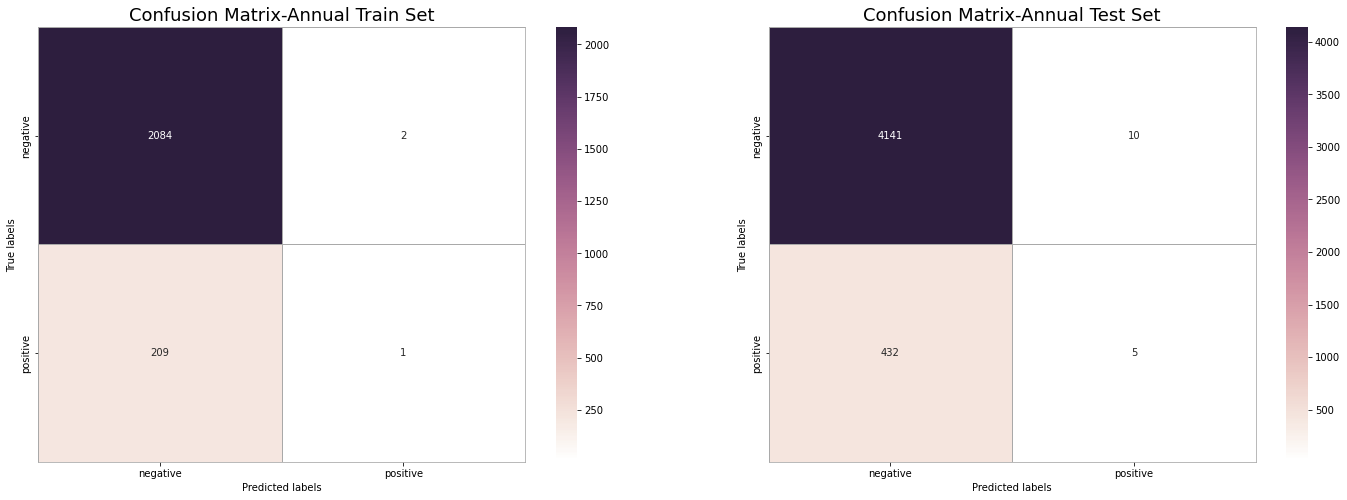

In [0]:
# True values and Predict values
y_true = predTest_lr.select("response")
y_true = y_true.toPandas()
 
y_pred = predTest_lr.select("prediction")
y_pred = y_pred.toPandas()
 
y_pred_train = predTrain_lr.select("prediction")
y_pred_train = y_pred_train.toPandas()
 
y_true_train = predTrain_lr.select("response")
y_true_train = y_true_train.toPandas()
 
# Confusion Matrix
conf_matrix_lr = confusion_matrix(y_true, y_pred)
conf_matrix_train_lr = confusion_matrix(y_true_train, y_pred_train)
 
fig, ax = plt.subplots(ncols=2,figsize=(24,8))
 
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
 
sns.heatmap(conf_matrix_train_lr, annot=True, fmt='g', ax=ax[0],cmap=cmap, linewidths=1, linecolor='darkgrey')
for _, spine in ax[0].spines.items():
    spine.set(visible=True,color='darkgrey')
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels'); 
ax[0].set_title('Confusion Matrix-Annual Train Set', fontsize=18); 
ax[0].xaxis.set_ticklabels(['negative','positive'])
ax[0].yaxis.set_ticklabels(['negative','positive'])
 
sns.heatmap(conf_matrix_lr, annot=True, fmt='g', ax=ax[1],cmap=cmap, linewidths=1, linecolor='darkgrey')
for _, spine in ax[1].spines.items():
    spine.set(visible=True,color='darkgrey')
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion Matrix-Annual Test Set', fontsize=18)
ax[1].xaxis.set_ticklabels(['negative','positive'])
ax[1].yaxis.set_ticklabels(['negative','positive'])
 
plt.show()

In [0]:
dt = DecisionTreeClassifier(featuresCol = "scaled_features",labelCol = 'response')
# print(dt.explainParams())
 
# evaluator = MulticlassClassificationEvaluator(labelCol="response")
 
paramGrid_dt = (ParamGridBuilder()
#                 .addGrid(dt.impurity, ["entropy","gini"])
                .addGrid(dt.maxDepth, [4,8,12])
                .addGrid(dt.maxBins, [20,40,60])
                .build())
 
# Create 5-fold CrossValidator
cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid_dt, 
                    evaluator=MulticlassClassificationEvaluator(labelCol="response"), numFolds=5, seed=1147)
cvModel_dt = cv_dt.fit(scaledTrain_annual)

predTrain_dt=cvModel_dt.transform(scaledTrain_annual)
predTest_dt=cvModel_dt.transform(scaledTest_annual)
bestModel_dt=cvModel_dt.bestModel
print("Best Param (MaxDepth)", bestModel_dt._java_obj.getMaxDepth())
print("Best Param (MaxBins)", bestModel_dt._java_obj.getMaxBins())

Best Param (MaxDepth) 4
Best Param (MaxBins) 20


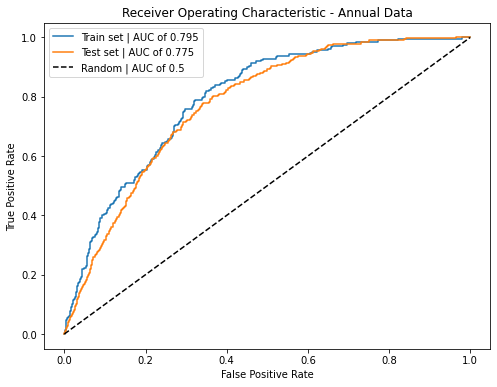

In [0]:
prob_train = predTrain_lr.select(vector_to_array("probability")[1]).rdd.keys().collect()
train_true = predTrain_lr.select("response").rdd.keys().collect()
fpr_train, tpr_train, thresholds = roc_curve(train_true, prob_train)
auc_train_lr  = BinaryClassificationEvaluator(labelCol="response").evaluate(predTrain_lr)
 
prob_test = predTest_lr.select(vector_to_array("probability")[1]).rdd.keys().collect()
test_true = predTest_lr.select("response").rdd.keys().collect()
fpr_test, tpr_test, thresholds = roc_curve(test_true, prob_test)
auc_test_lr  = BinaryClassificationEvaluator(labelCol="response").evaluate(predTest_lr)
 
plt.subplots(1, figsize=(8,6))
plt.title('Receiver Operating Characteristic - Annual Data')
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train_lr));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test_lr));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [0]:

lr = LogisticRegression(featuresCol = "scaled_features",labelCol = 'response', maxIter = 10, elasticNetParam=1)

paramGrid_lr = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.0001, 0.001, 0.01])# regularization parameter
                .build())
 
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid_lr, 
                    evaluator=BinaryClassificationEvaluator(labelCol="response"), numFolds=5, seed=1147)
 
mth_cvModel_lr = cv_lr.fit(scaledTrain_monthly)


mth_predTrain_lr =mth_cvModel_lr.transform(scaledTrain_monthly)
mth_predTest_lr =mth_cvModel_lr.transform(scaledTest_monthly)
mth_bestModel_lr =mth_cvModel_lr.bestModel
print('Best Param (regParam):', mth_bestModel_lr._java_obj.getRegParam())

Best Param (regParam): 0.0001


#####Plot coefficient values

#####Fit the training dataset and optimize the hyperparameters of the method.

#####Pre-process the data : Split the data in train and test set

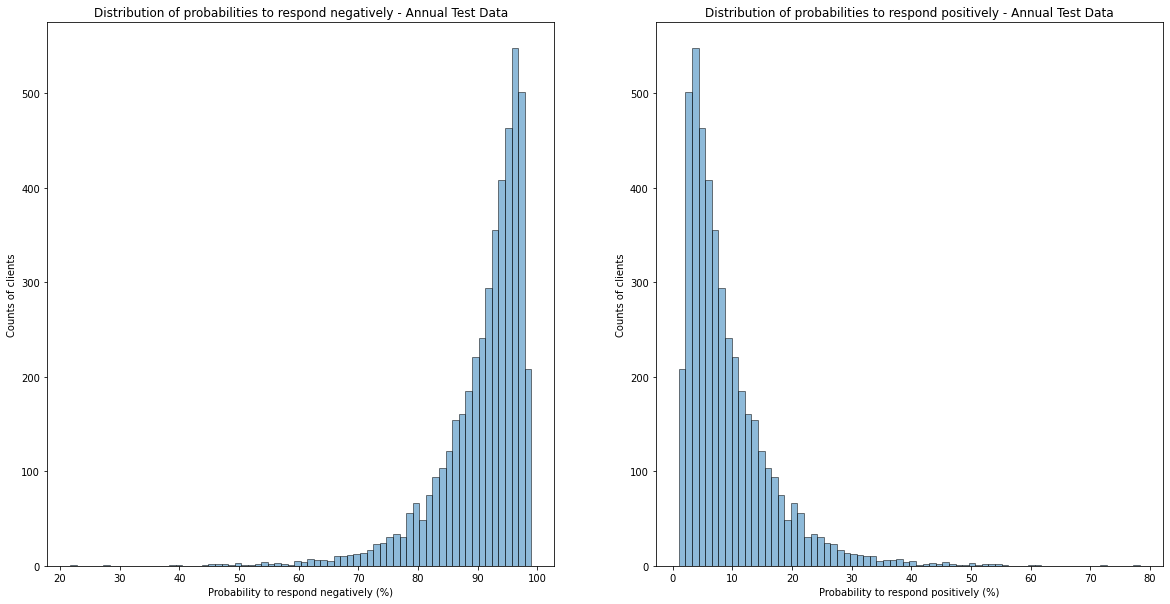

In [0]:
probTrain = predTrain_lr.select("probability")
probTrain_list = list(probTrain.select('probability').toPandas()['probability'])
prob_0_train = []
for i in range(probTrain.count()):
    prob_0_train.append(100 * probTrain_list[i][0])
prob_1_train = []
for i in range(probTrain.count()):
    prob_1_train.append(100 * probTrain_list[i][1])
    
probTest = predTest_lr.select("probability")
probTest_list = list(probTest.select('probability').toPandas()['probability'])
prob_0_test = []
for i in range(probTest.count()):
    prob_0_test.append(100 * probTest_list[i][0])
prob_1_test = []
for i in range(probTest.count()):
    prob_1_test.append(100 * probTest_list[i][1])
    
fig, ax = plt.subplots(ncols=2,figsize=(20,10))
ax[0].hist(prob_0_test, bins=70, alpha=0.5, histtype='bar', ec='black')
ax[0].set_title('Distribution of probabilities to respond negatively - Annual Test Data')
ax[0].set_xlabel('Probability to respond negatively (%)')
ax[0].set_ylabel('Counts of clients')
ax[1].hist(prob_1_test, bins=70,alpha=0.5, histtype='bar', ec='black')
ax[1].set_title('Distribution of probabilities to respond positively - Annual Test Data')
ax[1].set_xlabel('Probability to respond positively (%)')
ax[1].set_ylabel('Counts of clients')
plt.show()

In [0]:
predictionAndLabels_train = mth_predTrain_lr.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
precisionTrain_lr_mth = multi_metrics.weightedPrecision
recallTrain_lr_mth  = multi_metrics.weightedRecall
print("The precision score of monthly Training set is", "{:4.3f}".format(precisionTrain_lr_mth))
print("The precision score of monthly Training set is", "{:4.3f}".format(recallTrain_lr_mth))
# Test Set
predictionAndLabels = mth_predTest_lr.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels)
precisionTest_lr_mth  = multi_metrics.weightedPrecision
recallTest_lr_mth = multi_metrics.weightedRecall
print("The precision score of monthly Test set is", "{:4.3f}".format(precisionTest_lr_mth))
print("The precision score of monthly Test set is", "{:4.3f}".format(recallTest_lr_mth))

The precision score of monthly Training set is 0.823
The precision score of monthly Training set is 0.907
The precision score of monthly Test set is 0.820
The precision score of monthly Test set is 0.905


#####Plot coefficient values

##Logistic Regression with L1 Regularization
###Annual Data

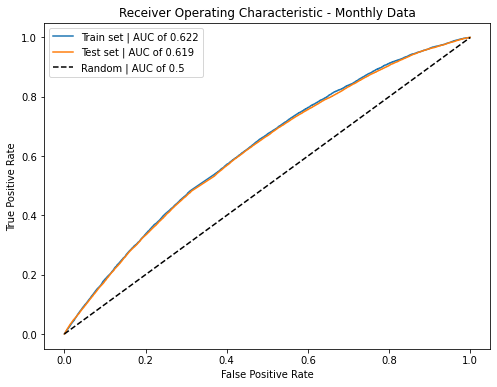

In [0]:
prob_train = mth_predTrain_lr.select(vector_to_array("probability")[1]).rdd.keys().collect()
train_true = mth_predTrain_lr.select("response").rdd.keys().collect()
fpr_train, tpr_train, thresholds = roc_curve(train_true, prob_train)
mth_auc_train_lr  = BinaryClassificationEvaluator(labelCol="response").evaluate(mth_predTrain_lr)
 
prob_test = mth_predTest_lr.select(vector_to_array("probability")[1]).rdd.keys().collect()
test_true = mth_predTest_lr.select("response").rdd.keys().collect()
fpr_test, tpr_test, thresholds = roc_curve(test_true, prob_test)
mth_auc_test_lr  = BinaryClassificationEvaluator(labelCol="response").evaluate(mth_predTest_lr)
 
plt.subplots(1, figsize=(8,6))
plt.title('Receiver Operating Characteristic - Monthly Data')
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(mth_auc_train_lr));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(mth_auc_test_lr));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

Out[9]: <AxesSubplot:>

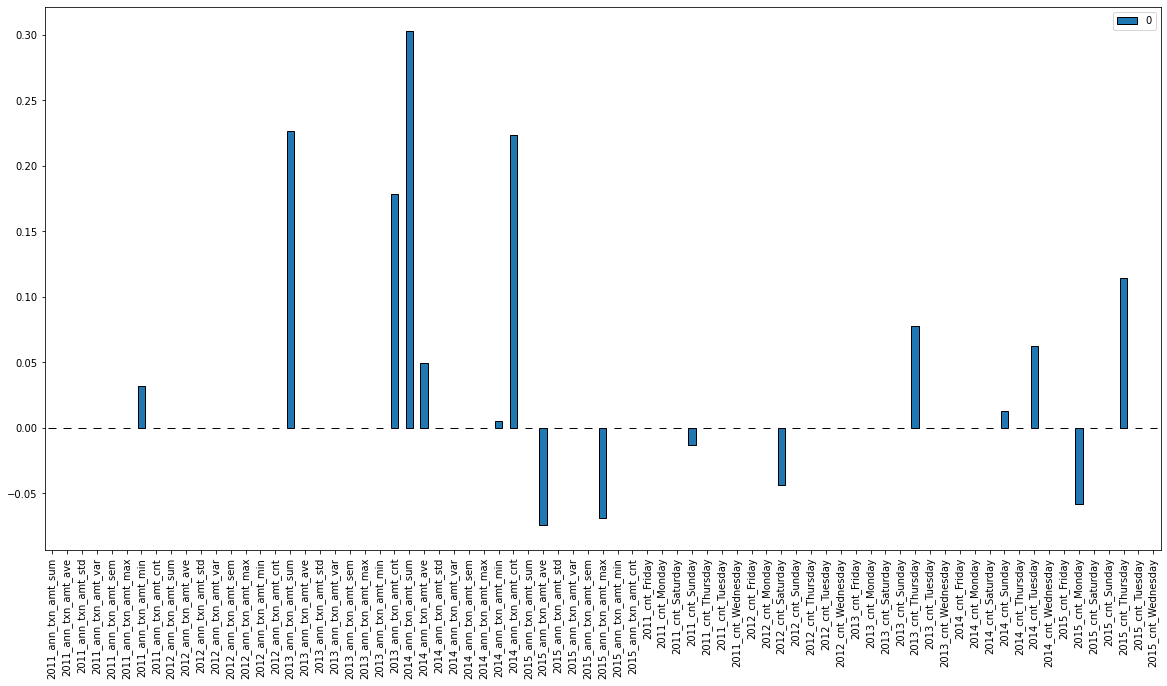

In [0]:
coef_lr= bestModel_lr.coefficientMatrix
coef_lr = pd.DataFrame(coef_lr.toArray())
coef_lr = coef_lr.transpose()
coef_lr.index = annual_colnames
coef_lr.plot(kind='bar',ec='black',figsize=(20,10))

In [0]:
predictionAndLabels_train = predTrain_lr.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
preciTrain_lr = multi_metrics.weightedPrecision
recallTrain_lr = multi_metrics.weightedRecall
print("The precision score of Annual Training set is", "{:4.3f}".format(preciTrain_lr))
print("The recall score of Annual Training set is", "{:4.3f}".format(recallTrain_lr))
# Test Set
predictionAndLabels = predTest_lr.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels)
preciTest_lr = multi_metrics.weightedPrecision
recallTest_lr = multi_metrics.weightedRecall
print("The precision score of Annual Test set is", "{:4.3f}".format(preciTest_lr))
print("The recall score of Annual Test set is", "{:4.3f}".format(recallTest_lr))

The precision score of Annual Training set is 0.856
The recall score of Annual Training set is 0.908
The precision score of Annual Test set is 0.851
The recall score of Annual Test set is 0.904


Out[15]: <AxesSubplot:>

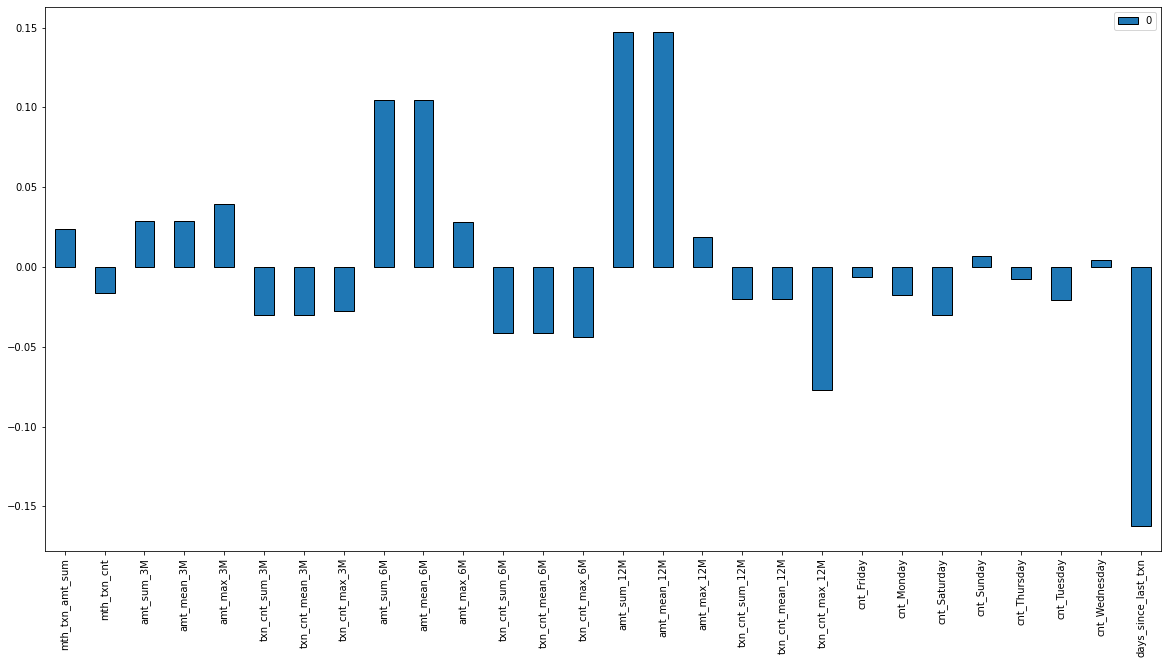

In [0]:
coef_mth = mth_bestModel_lr.coefficientMatrix
coef_mth = pd.DataFrame(coef_mth.toArray())
coef_mth = coef_mth.transpose()
coef_mth.index = mth_colnames
coef_mth.plot(kind='bar',ec='black',figsize=(20,10))

In [0]:
# Annual Data
annual_features = annual_features.drop("customer_id")
annual_features = annual_features.select([col(c).cast(DoubleType()) for c in annual_features.columns])
annual_features = annual_features.fillna(0)

# Monthly Data
mth_features = mth_features.drop("CLNT_NO","ME_DT")
mth_features = mth_features.select([col(c).cast(DoubleType()) for c in mth_features.columns])
mth_features = mth_features.fillna(0)

#####Plot confusion matrix and ROC curves for train/test set. Calculate precision/recall

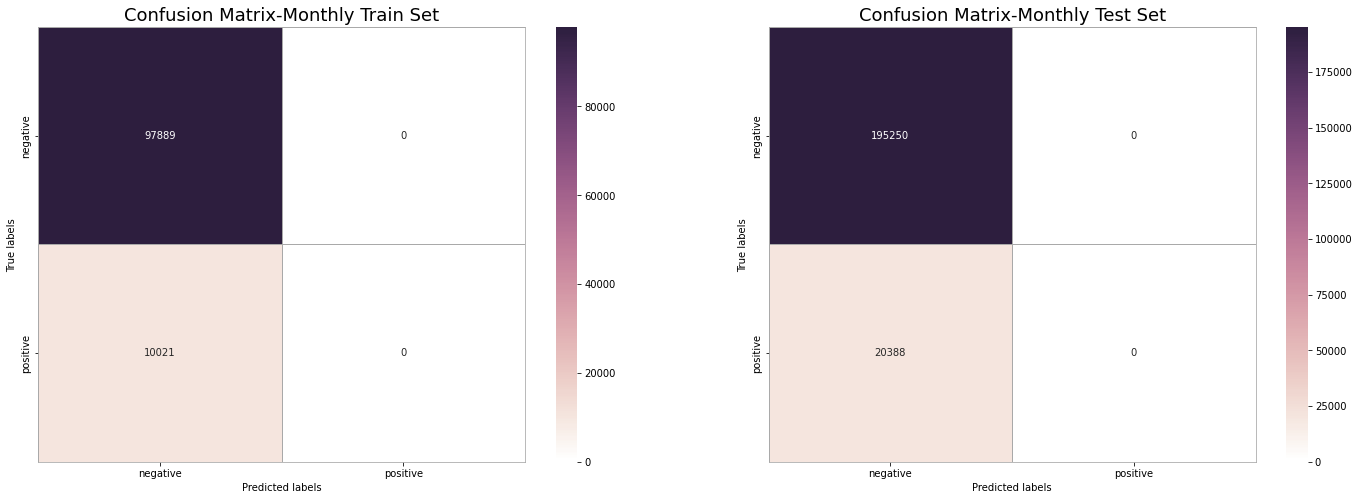

In [0]:
y_true = mth_predTest_lr.select("response")
y_true = y_true.toPandas()
 
y_pred = mth_predTest_lr.select("prediction")
y_pred = y_pred.toPandas()
 
y_pred_train = mth_predTrain_lr.select("prediction")
y_pred_train = y_pred_train.toPandas()
 
y_true_train = mth_predTrain_lr.select("response")
y_true_train = y_true_train.toPandas()
 
# Confusion Matrix
mth_conf_matrix_lr = confusion_matrix(y_true, y_pred)
mth_conf_matrix_train_lr = confusion_matrix(y_true_train, y_pred_train)
 
fig, ax = plt.subplots(ncols=2,figsize=(24,8))
 
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
 
sns.heatmap(mth_conf_matrix_train_lr, annot=True, fmt='g', ax=ax[0],cmap=cmap, linewidths=1, linecolor='darkgrey')
for _, spine in ax[0].spines.items():
    spine.set(visible=True,color='darkgrey')
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels'); 
ax[0].set_title('Confusion Matrix-Monthly Train Set', fontsize=18); 
ax[0].xaxis.set_ticklabels(['negative','positive'])
ax[0].yaxis.set_ticklabels(['negative','positive'])
 
sns.heatmap(mth_conf_matrix_lr, annot=True, fmt='g', ax=ax[1],cmap=cmap, linewidths=1, linecolor='darkgrey')
for _, spine in ax[1].spines.items():
    spine.set(visible=True,color='darkgrey')
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion Matrix-Monthly Test Set', fontsize=18)
ax[1].xaxis.set_ticklabels(['negative','positive'])
ax[1].yaxis.set_ticklabels(['negative','positive'])
 
plt.show()

#####Plot coefficient values

Out[21]: <AxesSubplot:>

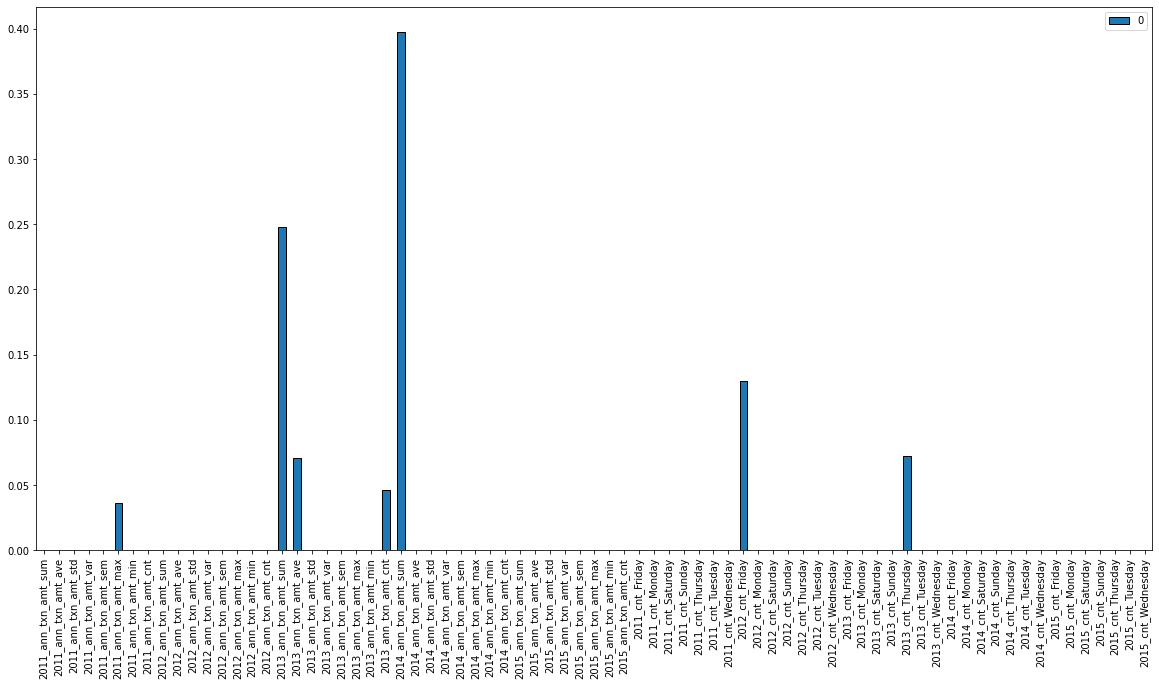

In [0]:
featureImportance_dt = bestModel_dt.featureImportances
featureImportance_dt = pd.DataFrame(featureImportance_dt.toArray())
featureImportance_dt.index = annual_colnames
featureImportance_dt.plot(kind='bar',ec='black',figsize=(20,10))

#####Plot probability distribution for test set

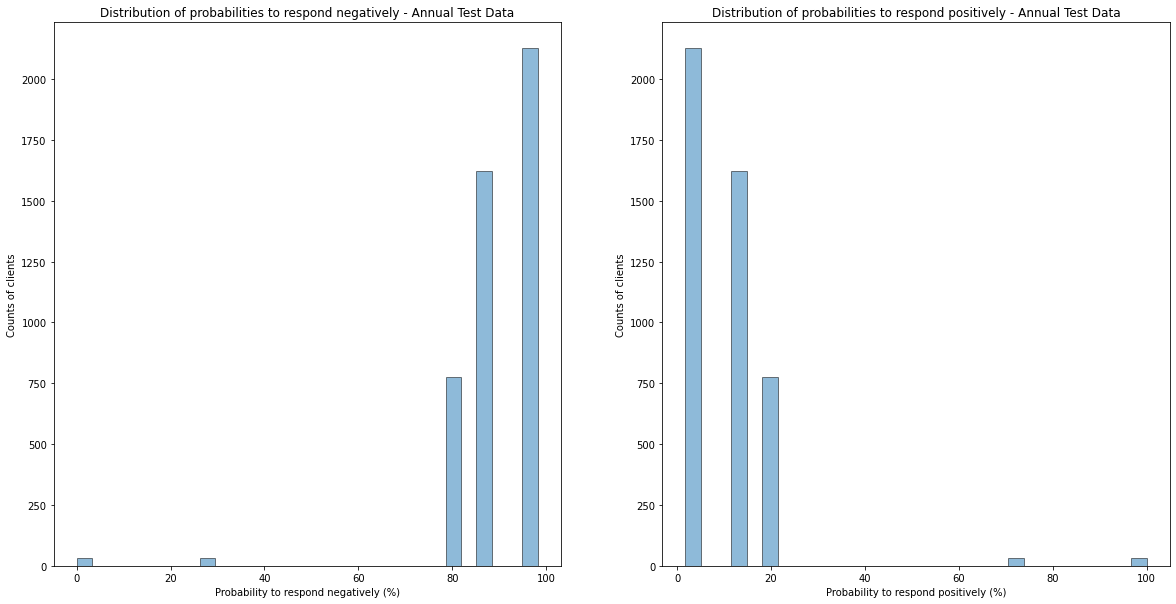

In [0]:
probTest_dt = predTest_dt.select("probability")
probTest_dt_list = list(probTest_dt.select('probability').toPandas()['probability'])
prob_0 = []
for i in range(probTest_dt.count()):
    prob_0.append(100 * probTest_dt_list[i][0])
prob_1 = []
for i in range(probTest_dt.count()):
    prob_1.append(100 * probTest_dt_list[i][1])
    
probTrain_dt = predTrain_dt.select("probability")
probTrain_list_dt = list(probTrain_dt.select('probability').toPandas()['probability'])
prob_0_train = []
for i in range(probTrain_dt.count()):
    prob_0_train.append(100 * probTrain_list_dt[i][0])
prob_1_train = []
for i in range(probTrain_dt.count()):
    prob_1_train.append(100 * probTrain_list_dt[i][1])
    
fig, ax = plt.subplots(ncols=2,figsize=(20,10))
ax[0].hist(prob_0, bins=30, alpha=0.5, histtype='bar', ec='black')
ax[0].set_title('Distribution of probabilities to respond negatively - Annual Test Data')
ax[0].set_xlabel('Probability to respond negatively (%)')
ax[0].set_ylabel('Counts of clients')
ax[1].hist(prob_1, bins=30, alpha=0.5, histtype='bar', ec='black')
ax[1].set_title('Distribution of probabilities to respond positively - Annual Test Data')
ax[1].set_xlabel('Probability to respond positively (%)')
ax[1].set_ylabel('Counts of clients')
plt.show()

#####Plot confusion matrix and ROC curves for train/test set. Calculate precision/recall

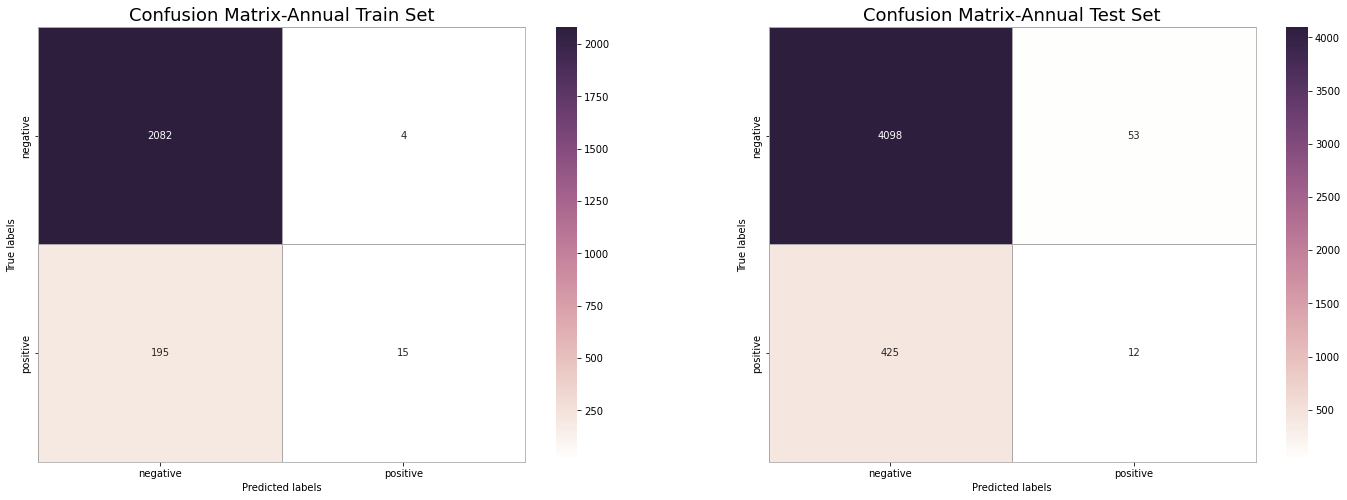

In [0]:
y_true = predTest_dt.select("response")
y_true = y_true.toPandas()
 
y_pred = predTest_dt.select("prediction")
y_pred = y_pred.toPandas()
 
y_pred_train = predTrain_dt.select("prediction")
y_pred_train = y_pred_train.toPandas()
 
y_true_train = predTrain_dt.select("response")
y_true_train = y_true_train.toPandas()
 
# Confusion Matrix
conf_matrix_dt = confusion_matrix(y_true, y_pred)
conf_matrix_train_dt = confusion_matrix(y_true_train, y_pred_train)
 
fig, ax = plt.subplots(ncols=2,figsize=(24,8))
 
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
 
sns.heatmap(conf_matrix_train_dt, annot=True, fmt='g', ax=ax[0],cmap=cmap, linewidths=1, linecolor='darkgrey')
for _, spine in ax[0].spines.items():
    spine.set(visible=True,color='darkgrey')
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels'); 
ax[0].set_title('Confusion Matrix-Annual Train Set', fontsize=18); 
ax[0].xaxis.set_ticklabels(['negative','positive'])
ax[0].yaxis.set_ticklabels(['negative','positive'])
 
sns.heatmap(conf_matrix_dt, annot=True, fmt='g', ax=ax[1],cmap=cmap, linewidths=1, linecolor='darkgrey')
for _, spine in ax[1].spines.items():
    spine.set(visible=True,color='darkgrey')
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion Matrix-Annual Test Set', fontsize=18)
ax[1].xaxis.set_ticklabels(['negative','positive'])
ax[1].yaxis.set_ticklabels(['negative','positive'])
 
plt.show()

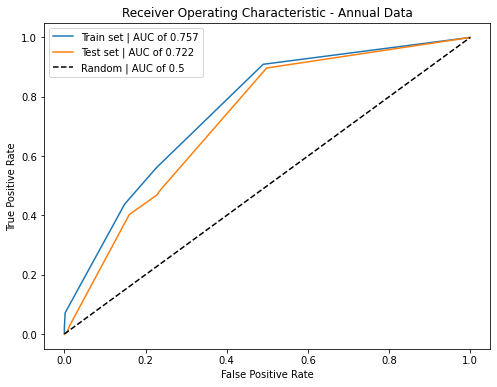

In [0]:
prob_train = predTrain_dt.select(vector_to_array("probability")[1]).rdd.keys().collect()
train_true = predTrain_dt.select("response").rdd.keys().collect()
fpr_train, tpr_train, thresholds = roc_curve(train_true, prob_train)
 
prob_test = predTest_dt.select(vector_to_array("probability")[1]).rdd.keys().collect()
test_true = predTest_dt.select("response").rdd.keys().collect()
fpr_test, tpr_test, thresholds = roc_curve(test_true, prob_test)
 
auc_train_dt  = auc(fpr_train, tpr_train)
 
auc_test_dt  = auc(fpr_test, tpr_test)
 
plt.subplots(1, figsize=(8,6))
plt.title('Receiver Operating Characteristic - Annual Data')
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train_dt));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test_dt));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [0]:
# Train Set
predictionAndLabels_train = predTrain_dt.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
precisionTrain_dt = multi_metrics.weightedPrecision
recallTrain_dt = multi_metrics.weightedRecall
print("The precision scroe of Annual Training Set is", "{:4.3f}".format(precisionTrain_dt))
print("The precision scroe of Annual Training Set is", "{:4.3f}".format(recallTrain_dt))
# Test Set
predictionAndLabels = predTest_dt.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels)
precisionTest_dt = multi_metrics.weightedPrecision
recallTest_dt = multi_metrics.weightedRecall
print("The precision scroe of Annual Test Set is", "{:4.3f}".format(precisionTest_dt))
print("The precision scroe of Annual Test Set is", "{:4.3f}".format(recallTest_dt))

The precision scroe of Annual Training Set is 0.903
The precision scroe of Annual Training Set is 0.913
The precision scroe of Annual Test Set is 0.837
The precision scroe of Annual Test Set is 0.896


##Decision Tree
###Monthly Data

#####Fit the training dataset and optimize the hyperparameters of the method.

In [0]:
dt = DecisionTreeClassifier(featuresCol = "scaled_features",labelCol = 'response')
  
paramGrid_dt = (ParamGridBuilder()
                .addGrid(dt.maxDepth, [4,6,8])
                .addGrid(dt.maxBins, [20,40,60])
                .build())
 
cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid_dt, 
                    evaluator=MulticlassClassificationEvaluator(labelCol="response"), numFolds=5, seed=1147)
 
mth_cvModel_dt = cv_dt.fit(scaledTrain_monthly)

mth_predTrain_dt=mth_cvModel_dt.transform(scaledTrain_monthly)
mth_predTest_dt=mth_cvModel_dt.transform(scaledTest_monthly)
mth_bestModel_dt=mth_cvModel_dt.bestModel
print("Best Param (MaxDepth)", mth_bestModel_dt._java_obj.getMaxDepth())
print("Best Param (MaxBins)", mth_bestModel_dt._java_obj.getMaxBins())

Best Param (MaxDepth) 8
Best Param (MaxBins) 60


#####Plot coefficient values

Out[27]: <AxesSubplot:>

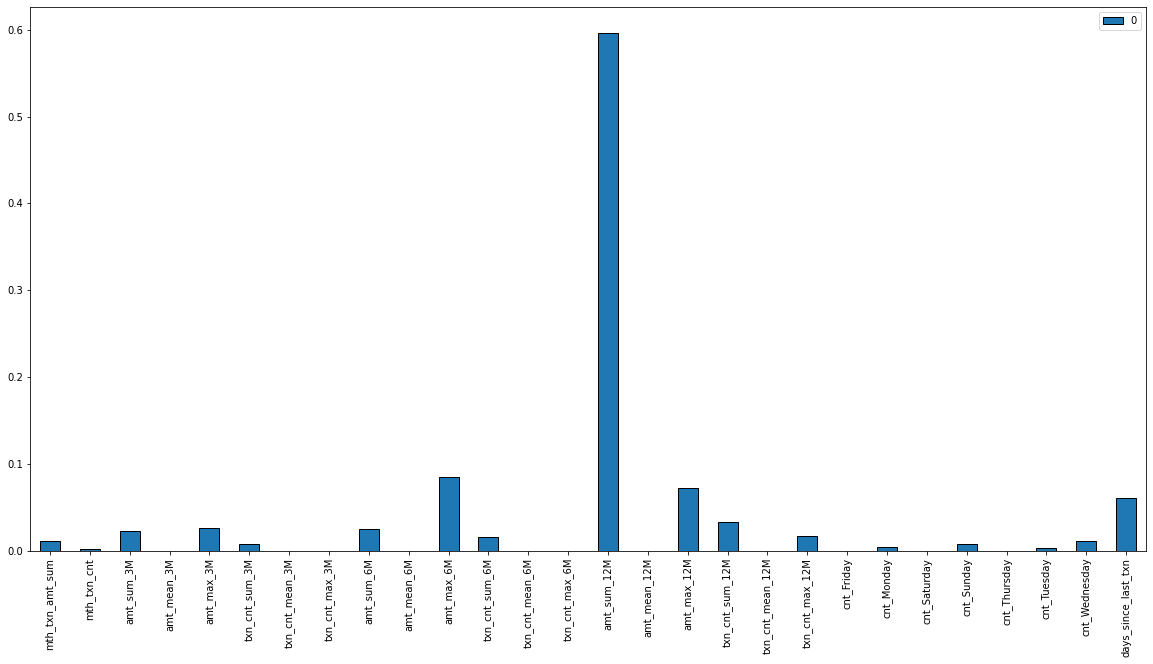

In [0]:
featureImportance_dt_mth = mth_bestModel_dt.featureImportances
featureImportance_dt_mth = pd.DataFrame(featureImportance_dt_mth.toArray())
featureImportance_dt_mth.index = mth_colnames
featureImportance_dt_mth.plot(kind='bar',ec='black',figsize=(20,10))

d
#####Plot probability distribution for test set

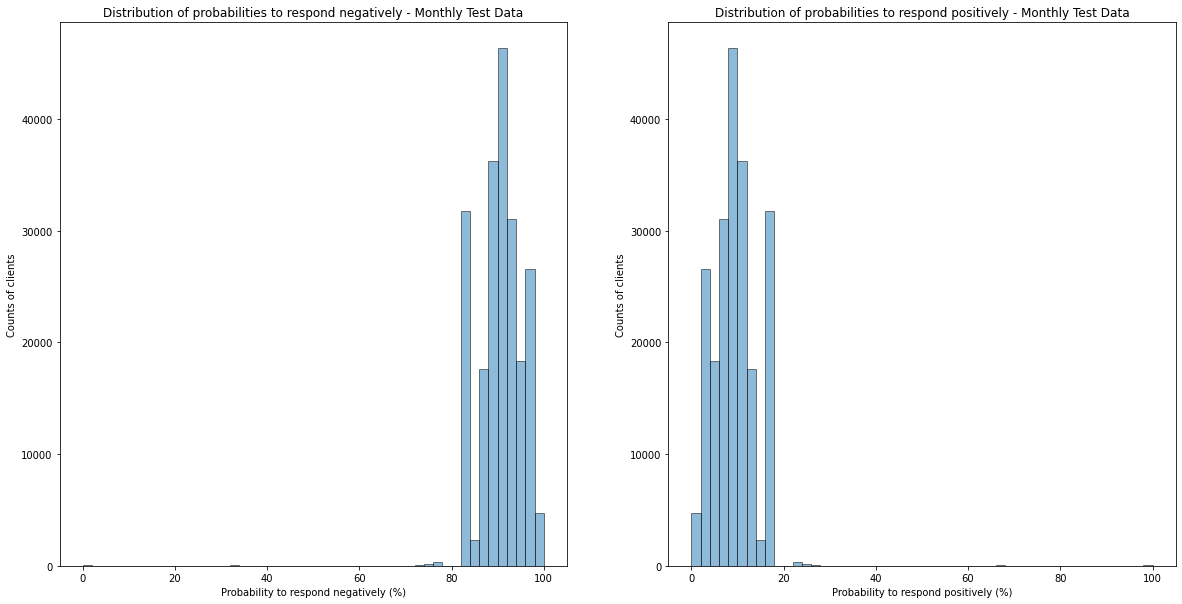

In [0]:
mth_probTest_dt = mth_predTest_dt.select("probability")
mth_probTest_dt_list = list(mth_probTest_dt.select('probability').toPandas()['probability'])
prob_0 = []
for i in range(mth_probTest_dt.count()):
    prob_0.append(100 * mth_probTest_dt_list[i][0])
prob_1 = []
for i in range(mth_probTest_dt.count()):
    prob_1.append(100 * mth_probTest_dt_list[i][1])
    
mth_probTrain_dt = mth_predTrain_dt.select("probability")
mth_probTrain_list_dt = list(mth_probTrain_dt.select('probability').toPandas()['probability'])
prob_0_train = []
for i in range(mth_probTrain_dt.count()):
    prob_0_train.append(100 * mth_probTrain_list_dt[i][0])
prob_1_train = []
for i in range(mth_probTrain_dt.count()):
    prob_1_train.append(100 * mth_probTrain_list_dt[i][1])
    
fig, ax = plt.subplots(ncols=2,figsize=(20,10))
ax[0].hist(prob_0, bins=50,alpha=0.5, histtype='bar', ec='black')
ax[0].set_title('Distribution of probabilities to respond negatively - Monthly Test Data')
ax[0].set_xlabel('Probability to respond negatively (%)')
ax[0].set_ylabel('Counts of clients')
ax[1].hist(prob_1, bins=50,alpha=0.5, histtype='bar', ec='black')
ax[1].set_title('Distribution of probabilities to respond positively - Monthly Test Data')
ax[1].set_xlabel('Probability to respond positively (%)')
ax[1].set_ylabel('Counts of clients')
plt.show()

#####Plot confusion matrix and ROC curves for train/test set. Calculate precision/recall

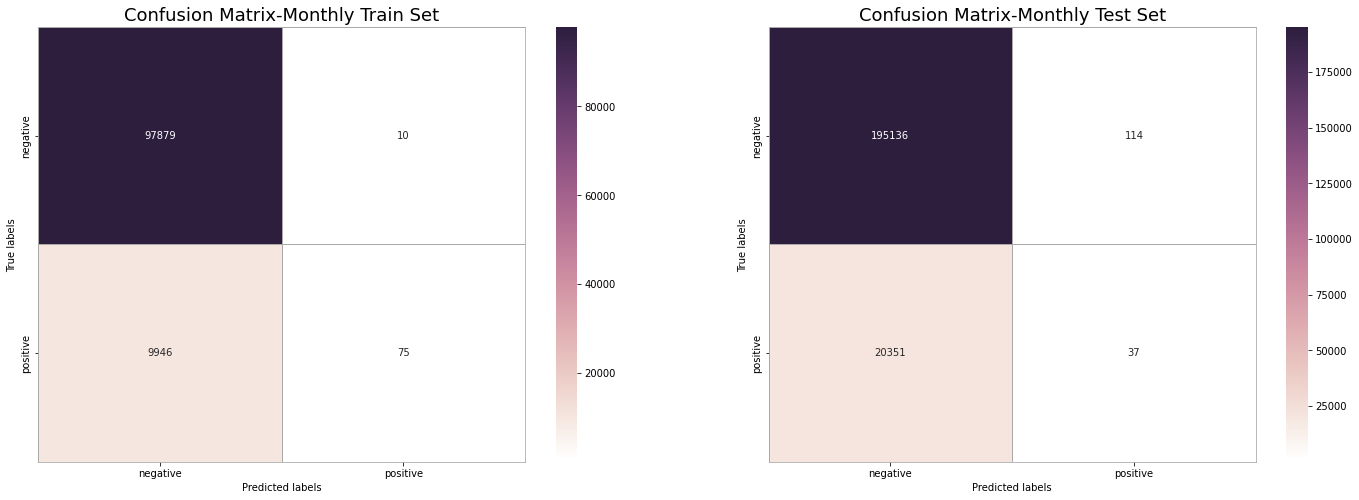

In [0]:
y_true = mth_predTest_dt.select("response")
y_true = y_true.toPandas()
 
y_pred = mth_predTest_dt.select("prediction")
y_pred = y_pred.toPandas()
 
y_pred_train = mth_predTrain_dt.select("prediction")
y_pred_train = y_pred_train.toPandas()
 
y_true_train = mth_predTrain_dt.select("response")
y_true_train = y_true_train.toPandas()
 
# Confusion Matrix
mth_conf_matrix_dt = confusion_matrix(y_true, y_pred)
mth_conf_matrix_train_dt = confusion_matrix(y_true_train, y_pred_train)
 
fig, ax = plt.subplots(ncols=2,figsize=(24,8))
 
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
 
sns.heatmap(mth_conf_matrix_train_dt, annot=True, fmt='g', ax=ax[0],cmap=cmap, linewidths=1, linecolor='darkgrey')
for _, spine in ax[0].spines.items():
    spine.set(visible=True,color='darkgrey')
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels'); 
ax[0].set_title('Confusion Matrix-Monthly Train Set', fontsize=18); 
ax[0].xaxis.set_ticklabels(['negative','positive'])
ax[0].yaxis.set_ticklabels(['negative','positive'])
 
sns.heatmap(mth_conf_matrix_dt, annot=True, fmt='g', ax=ax[1],cmap=cmap, linewidths=1, linecolor='darkgrey')
for _, spine in ax[1].spines.items():
    spine.set(visible=True,color='darkgrey')
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion Matrix-Monthly Test Set', fontsize=18)
ax[1].xaxis.set_ticklabels(['negative','positive'])
ax[1].yaxis.set_ticklabels(['negative','positive'])
 
plt.show()

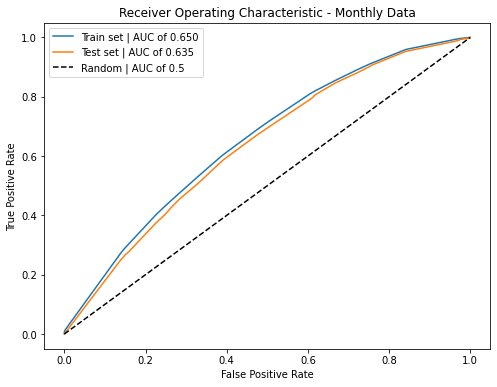

In [0]:
prob_train = mth_predTrain_dt.select(vector_to_array("probability")[1]).rdd.keys().collect()
train_true = mth_predTrain_dt.select("response").rdd.keys().collect()
fpr_train, tpr_train, thresholds = roc_curve(train_true, prob_train)
 
prob_test = mth_predTest_dt.select(vector_to_array("probability")[1]).rdd.keys().collect()
test_true = mth_predTest_dt.select("response").rdd.keys().collect()
fpr_test, tpr_test, thresholds = roc_curve(test_true, prob_test)
 
mth_auc_train_dt  = auc(fpr_train, tpr_train)
 
mth_auc_test_dt  = auc(fpr_test, tpr_test)
 
plt.subplots(1, figsize=(8,6))
plt.title('Receiver Operating Characteristic - Monthly Data')
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(mth_auc_train_dt));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(mth_auc_test_dt ));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [0]:
predictionAndLabels_train = mth_predTrain_dt.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
mth_precisionTrain_dt = multi_metrics.weightedPrecision
mth_recallTrain_dt = multi_metrics.weightedRecall
print("The precision scroe of Monthly Training Set is", "{:4.3f}".format(mth_precisionTrain_dt))
print("The precision scroe of Monthly Training Set is", "{:4.3f}".format(mth_recallTrain_dt))
# Test Set
predictionAndLabels = mth_predTest_dt.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels)
mth_precisionTest_dt = multi_metrics.weightedPrecision
mth_recallTest_dt = multi_metrics.weightedRecall
print("The precision scroe of Monthly Test Set is", "{:4.3f}".format(mth_precisionTest_dt))
print("The precision scroe of Monthly Test Set is", "{:4.3f}".format(mth_recallTest_dt))

The precision scroe of Monthly Training Set is 0.905
The precision scroe of Monthly Training Set is 0.908
The precision scroe of Monthly Test Set is 0.843
The precision scroe of Monthly Test Set is 0.905


##Random Forest
###Annual Data

#####Fit the training dataset and optimize the hyperparameters of the method.

In [0]:
rf = RandomForestClassifier(featuresCol = "scaled_features",labelCol = 'response')
 
paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.numTrees, [10, 20, 30])
                .addGrid(rf.featureSubsetStrategy,["all","sqrt","log2"])
                .build())
 
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf, 
                    evaluator=MulticlassClassificationEvaluator(labelCol="response"), numFolds=5, seed=1147)
cvModel_rf = cv_rf.fit(scaledTrain_annual)

predTrain_rf=cvModel_rf.transform(scaledTrain_annual)
predTest_rf=cvModel_rf.transform(scaledTest_annual)
bestModel_rf=cvModel_rf.bestModel
print("Best Param (NumTrees)", bestModel_rf._java_obj.getNumTrees())
print("Best Param (FeatureSubsetStrategy)", bestModel_rf._java_obj.getFeatureSubsetStrategy())

Best Param (NumTrees) 30
Best Param (FeatureSubsetStrategy) all


#####Plot coefficient values

Out[33]: <AxesSubplot:>

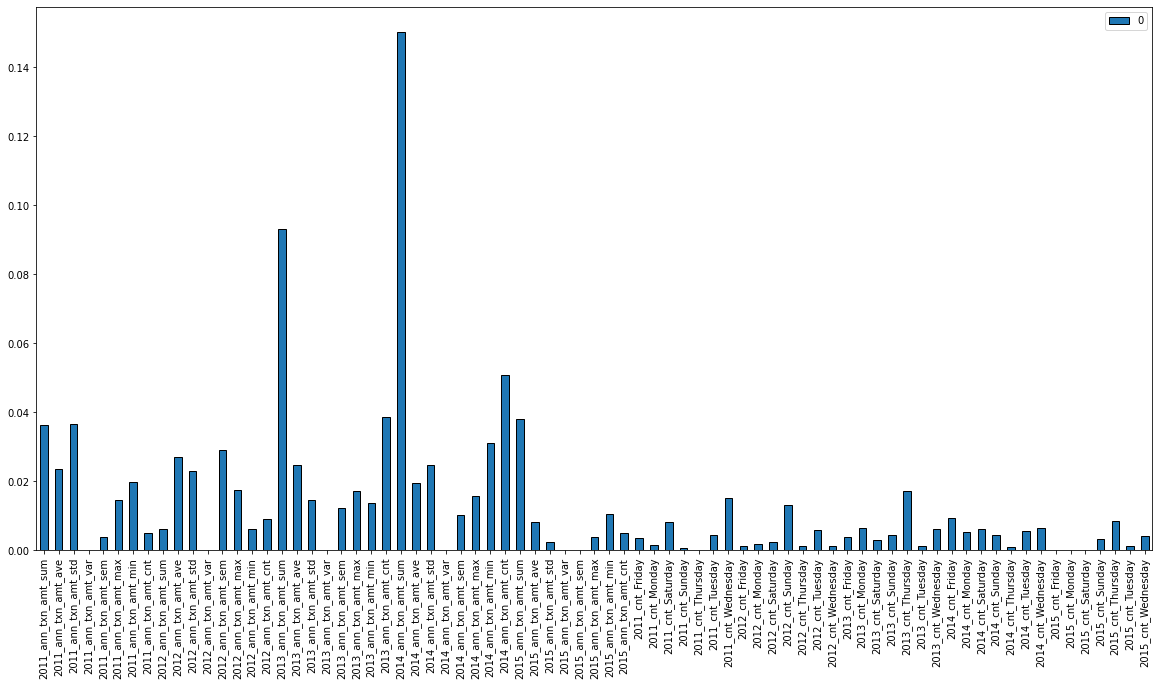

In [0]:
featureImportance_rf= bestModel_rf.featureImportances
featureImportance_rf= pd.DataFrame(featureImportance_rf.toArray())
featureImportance_rf.index = annual_colnames
featureImportance_rf.plot(kind='bar',ec='black',figsize=(20,10))

#####Plot probability distribution for test set

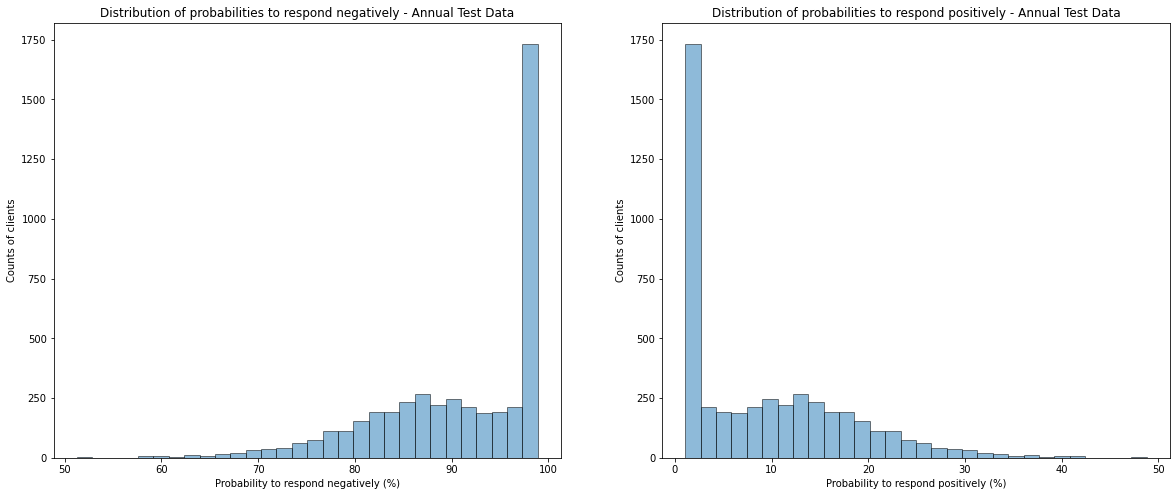

In [0]:
probTest_rf = predTest_rf.select("probability")
probTest_rf_list = list(probTest_rf.select('probability').toPandas()['probability'])
prob_0 = []
for i in range(probTest_rf.count()):
    prob_0.append(100 * probTest_rf_list[i][0])
prob_1 = []
for i in range(probTest_rf.count()):
    prob_1.append(100 * probTest_rf_list[i][1])
    
probTrain_rf = predTrain_rf.select("probability")
probTrain_rf_list = list(probTrain_rf.select('probability').toPandas()['probability'])
prob_0_train = []
for i in range(probTrain_rf.count()):
    prob_0_train.append(100 * probTrain_rf_list[i][0])
prob_1_train = []
for i in range(probTrain_rf.count()):
    prob_1_train.append(100 * probTrain_rf_list[i][1])
    
fig, ax = plt.subplots(ncols=2,figsize=(20,8))
ax[0].hist(prob_0, bins = 30, alpha=0.5, histtype='bar', ec='black')
ax[0].set_title('Distribution of probabilities to respond negatively - Annual Test Data')
ax[0].set_xlabel('Probability to respond negatively (%)')
ax[0].set_ylabel('Counts of clients')
ax[1].hist(prob_1, bins = 30, alpha=0.5, histtype='bar', ec='black')
ax[1].set_title('Distribution of probabilities to respond positively - Annual Test Data')
ax[1].set_xlabel('Probability to respond positively (%)')
ax[1].set_ylabel('Counts of clients')
plt.show()

#####Plot confusion matrix and ROC curves for train/test set. Calculate precision/recall

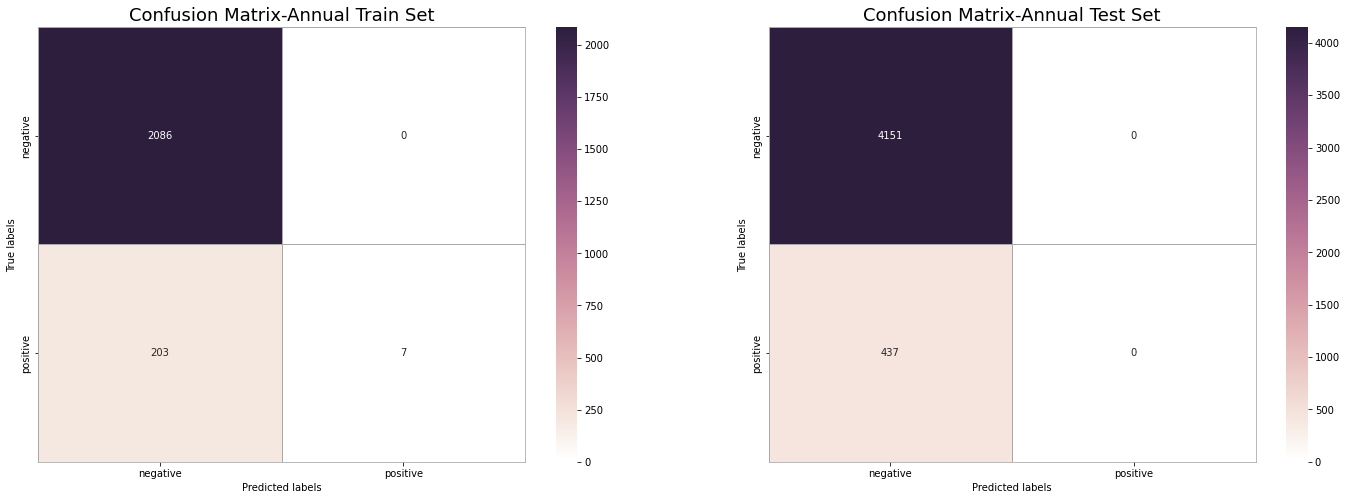

In [0]:
y_true = predTest_rf.select("response")
y_true = y_true.toPandas()
 
y_pred = predTest_rf.select("prediction")
y_pred = y_pred.toPandas()
 
y_pred_train = predTrain_rf.select("prediction")
y_pred_train = y_pred_train.toPandas()
 
y_true_train = predTrain_rf.select("response")
y_true_train = y_true_train.toPandas()
 
# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_true, y_pred)
conf_matrix_train_rf = confusion_matrix(y_true_train, y_pred_train)
 
fig, ax = plt.subplots(ncols=2,figsize=(24,8))
 
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
 
sns.heatmap(conf_matrix_train_rf, annot=True, fmt='g', ax=ax[0],cmap=cmap, linewidths=1, linecolor='darkgrey')
for _, spine in ax[0].spines.items():
    spine.set(visible=True,color='darkgrey')
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels'); 
ax[0].set_title('Confusion Matrix-Annual Train Set', fontsize=18); 
ax[0].xaxis.set_ticklabels(['negative','positive'])
ax[0].yaxis.set_ticklabels(['negative','positive'])
 
sns.heatmap(conf_matrix_rf, annot=True, fmt='g', ax=ax[1],cmap=cmap, linewidths=1, linecolor='darkgrey')
for _, spine in ax[1].spines.items():
    spine.set(visible=True,color='darkgrey')
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion Matrix-Annual Test Set', fontsize=18)
ax[1].xaxis.set_ticklabels(['negative','positive'])
ax[1].yaxis.set_ticklabels(['negative','positive'])
 
plt.show()

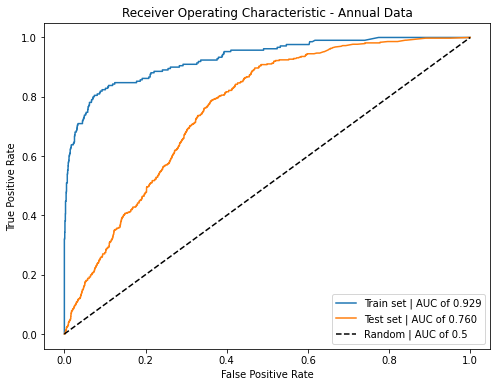

In [0]:
# ROC curve
prob_train = predTrain_rf.select(vector_to_array("probability")[1]).rdd.keys().collect()
train_true = predTrain_rf.select("response").rdd.keys().collect()
fpr_train, tpr_train, thresholds = roc_curve(train_true, prob_train)
 
prob_test = predTest_rf.select(vector_to_array("probability")[1]).rdd.keys().collect()
test_true = predTest_rf.select("response").rdd.keys().collect()
fpr_test, tpr_test, thresholds = roc_curve(test_true, prob_test)
 
auc_train_rf  = auc(fpr_train, tpr_train)
 
auc_test_rf  = auc(fpr_test, tpr_test)
 
plt.subplots(1, figsize=(8,6))
plt.title('Receiver Operating Characteristic - Annual Data')
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train_rf));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test_rf));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [0]:
# Precision/Recall
# Train Set
predictionAndLabels_train = predTrain_rf.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
precisionTrain_rf= multi_metrics.weightedPrecision
recallTrain_rf = multi_metrics.weightedRecall
print("The precision scroe of Annual Training Set is", "{:4.3f}".format(precisionTrain_rf))
print("The precision scroe of Annual Training Set is", "{:4.3f}".format(recallTrain_rf))
# Test Set
predictionAndLabels = predTest_rf.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels)
precisionTest_rf = multi_metrics.weightedPrecision
recallTest_rf = multi_metrics.weightedRecall
print("The precision scroe of Annual Test Set is", "{:4.3f}".format(precisionTest_rf))
print("The precision scroe of Annual Test Set is", "{:4.3f}".format(recallTest_rf))

The precision scroe of Annual Training Set is 0.919
The precision scroe of Annual Training Set is 0.912
The precision scroe of Annual Test Set is 0.819
The precision scroe of Annual Test Set is 0.905


##Random Forest
###Monthly Data

#####Fit the training dataset and optimize the hyperparameters of the method.

In [0]:
rf = RandomForestClassifier(featuresCol = "scaled_features",labelCol = 'response')
  
paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.numTrees, [10, 20, 30])
                .addGrid(rf.featureSubsetStrategy,["all","sqrt","log2"])
                .build())
 
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf, 
                    evaluator=MulticlassClassificationEvaluator(labelCol="response"), numFolds=5, seed=1147)
 
mth_cvModel_rf = cv_rf.fit(scaledTrain_monthly)


mth_predTrain_rf=mth_cvModel_rf.transform(scaledTrain_monthly)
mth_predTest_rf=mth_cvModel_rf.transform(scaledTest_monthly)
mth_bestModel_rf=mth_cvModel_rf.bestModel
print("Best Param (NumTrees)", mth_bestModel_rf._java_obj.getNumTrees())
print("Best Param (FeatureSubsetStrategy)", mth_bestModel_rf._java_obj.getFeatureSubsetStrategy())

Best Param (NumTrees) 10
Best Param (FeatureSubsetStrategy) sqrt


d
#####Plot coefficient values

Out[39]: <AxesSubplot:>

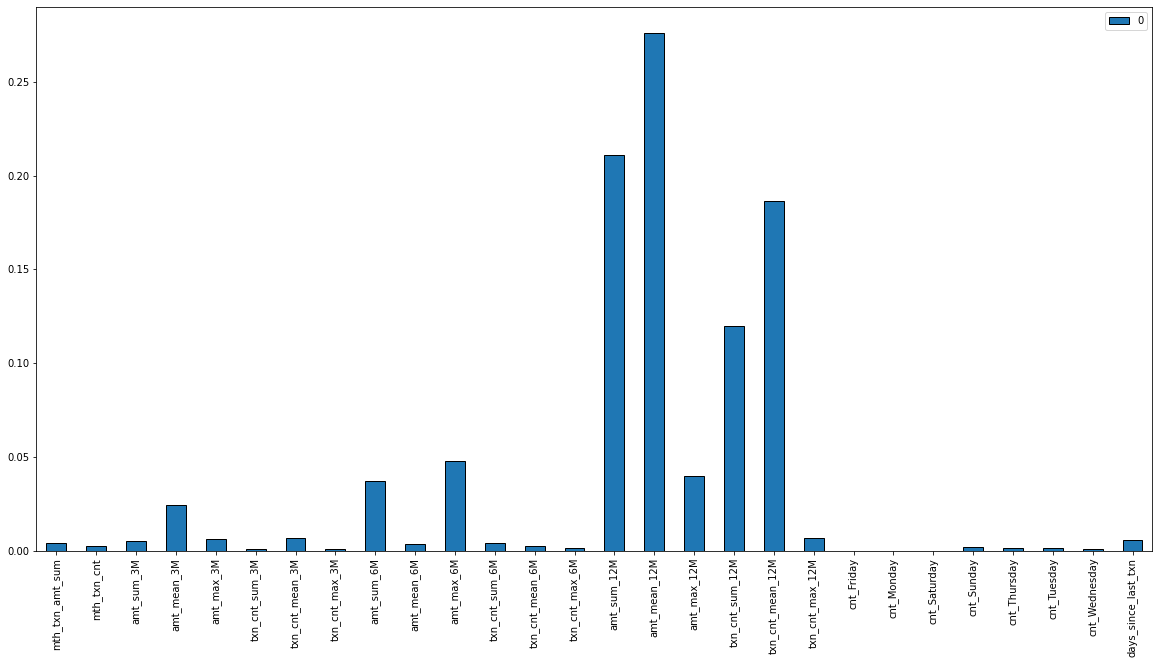

In [0]:
mth_featureImportance_rf= mth_bestModel_rf.featureImportances
mth_featureImportance_rf= pd.DataFrame(mth_featureImportance_rf.toArray())
mth_featureImportance_rf.index = mth_colnames
mth_featureImportance_rf.plot(kind='bar',ec='black',figsize=(20,10))

#####Plot probability distribution for test set

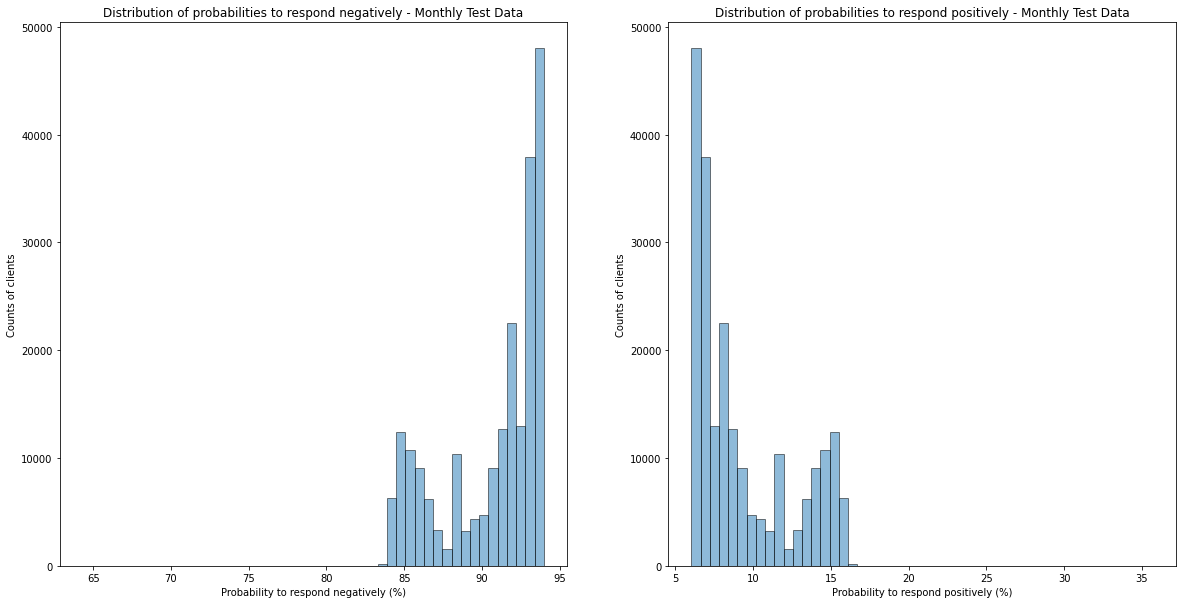

In [0]:
mth_probTest_rf = mth_predTest_rf.select("probability")
mth_probTest_rf_list = list(mth_probTest_rf.select('probability').toPandas()['probability'])
prob_0 = []
for i in range(mth_probTest_rf.count()):
    prob_0.append(100 * mth_probTest_rf_list[i][0])
prob_1 = []
for i in range(mth_probTest_rf.count()):
    prob_1.append(100 * mth_probTest_rf_list[i][1])
    
mth_probTrain_rf = mth_predTrain_rf.select("probability")
mth_probTrain_rf_list = list(mth_probTrain_rf.select('probability').toPandas()['probability'])
prob_0_train = []
for i in range(mth_probTrain_rf.count()):
    prob_0_train.append(100 * mth_probTrain_rf_list[i][0])
prob_1_train = []
for i in range(mth_probTrain_rf.count()):
    prob_1_train.append(100 * mth_probTrain_rf_list[i][1])
    
fig, ax = plt.subplots(ncols=2,figsize=(20,10))
ax[0].hist(prob_0, bins=50,alpha=0.5, histtype='bar', ec='black')
ax[0].set_title('Distribution of probabilities to respond negatively - Monthly Test Data')
ax[0].set_xlabel('Probability to respond negatively (%)')
ax[0].set_ylabel('Counts of clients')
ax[1].hist(prob_1, bins=50,alpha=0.5, histtype='bar', ec='black')
ax[1].set_title('Distribution of probabilities to respond positively - Monthly Test Data')
ax[1].set_xlabel('Probability to respond positively (%)')
ax[1].set_ylabel('Counts of clients')
plt.show()

#####Plot confusion matrix and ROC curves for train/test set. Calculate precision/recall

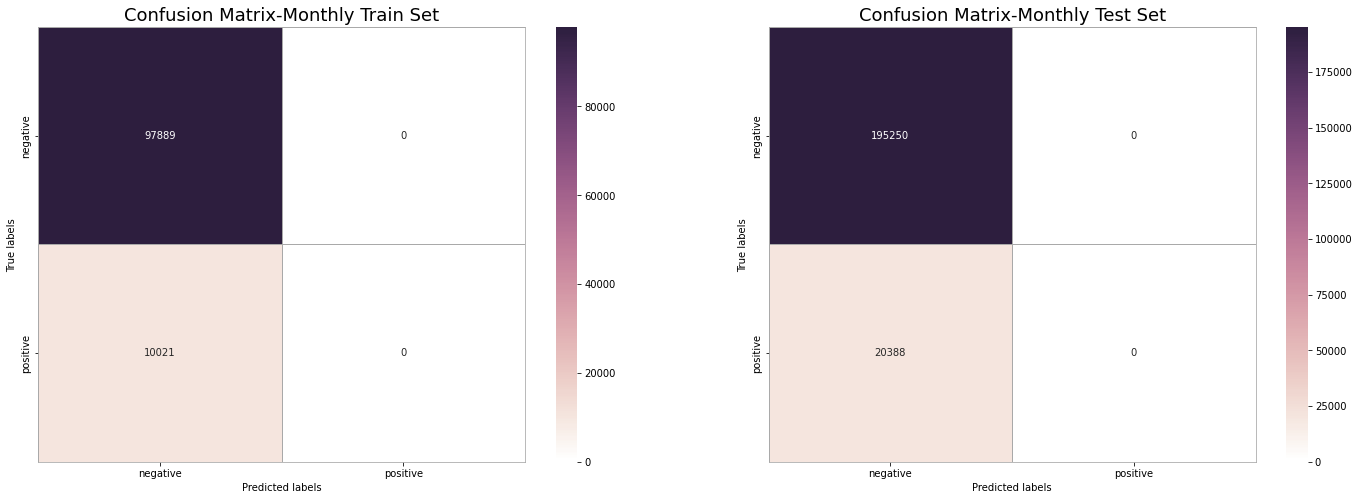

In [0]:
y_true = mth_predTest_rf.select("response")
y_true = y_true.toPandas()
 
y_pred = mth_predTest_rf.select("prediction")
y_pred = y_pred.toPandas()
 
y_pred_train = mth_predTrain_rf.select("prediction")
y_pred_train = y_pred_train.toPandas()
 
y_true_train = mth_predTrain_rf.select("response")
y_true_train = y_true_train.toPandas()
 
# Confusion Matrix
mth_conf_matrix_rf = confusion_matrix(y_true, y_pred)
mth_conf_matrix_train_rf = confusion_matrix(y_true_train, y_pred_train)
 
fig, ax = plt.subplots(ncols=2,figsize=(24,8))
 
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
 
sns.heatmap(mth_conf_matrix_train_rf, annot=True, fmt='g', ax=ax[0],cmap=cmap, linewidths=1, linecolor='darkgrey')
for _, spine in ax[0].spines.items():
    spine.set(visible=True,color='darkgrey')
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels'); 
ax[0].set_title('Confusion Matrix-Monthly Train Set', fontsize=18); 
ax[0].xaxis.set_ticklabels(['negative','positive'])
ax[0].yaxis.set_ticklabels(['negative','positive'])
 
sns.heatmap(mth_conf_matrix_rf, annot=True, fmt='g', ax=ax[1],cmap=cmap, linewidths=1, linecolor='darkgrey')
for _, spine in ax[1].spines.items():
    spine.set(visible=True,color='darkgrey')
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion Matrix-Monthly Test Set', fontsize=18)
ax[1].xaxis.set_ticklabels(['negative','positive'])
ax[1].yaxis.set_ticklabels(['negative','positive'])
 
plt.show()

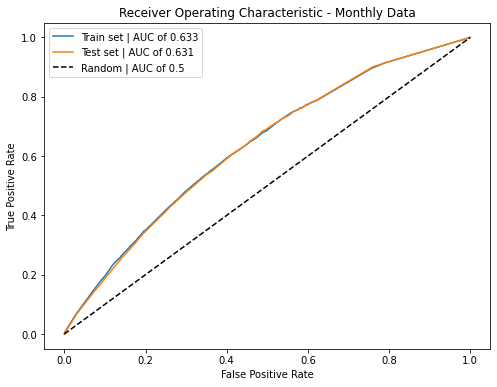

In [0]:
# ROC curve
prob_train = mth_predTrain_rf.select(vector_to_array("probability")[1]).rdd.keys().collect()
train_true = mth_predTrain_rf.select("response").rdd.keys().collect()
fpr_train, tpr_train, thresholds = roc_curve(train_true, prob_train)
mth_auc_train_rf  = auc(fpr_train, tpr_train)
 
prob_test = mth_predTest_rf.select(vector_to_array("probability")[1]).rdd.keys().collect()
test_true = mth_predTest_rf.select("response").rdd.keys().collect()
fpr_test, tpr_test, thresholds = roc_curve(test_true, prob_test)
mth_auc_test_rf  = auc(fpr_test, tpr_test)
 
plt.subplots(1, figsize=(8,6))
plt.title('Receiver Operating Characteristic - Monthly Data')
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(mth_auc_train_rf));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(mth_auc_test_rf));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [0]:
# Train Set
predictionAndLabels_train = mth_predTrain_rf.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels_train)
mth_precisionTrain_rf = multi_metrics.weightedPrecision
mth_recallTrain_rf = multi_metrics.weightedRecall
print("The precision score of monthly Training set is", "{:4.3f}".format(mth_precisionTrain_rf))
print("The precision score of monthly Training set is", "{:4.3f}".format(mth_recallTrain_rf))
# Test Set
predictionAndLabels = mth_predTest_rf.select("prediction","response").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels)
mth_precisionTest_rf = multi_metrics.weightedPrecision
mth_recallTest_rf = multi_metrics.weightedRecall
print("The precision score of monthly Test set is","{:4.3f}".format(mth_precisionTest_rf))
print("The precision score of monthly Test set is", "{:4.3f}".format(mth_recallTest_rf))

The precision score of monthly Training set is 0.823
The precision score of monthly Training set is 0.907
The precision score of monthly Test set is 0.820
The precision score of monthly Test set is 0.905


#1.3 Compute of methods

| Model  | Feature  |  Precision negative | Precision positive  |  Recall negative | Recall positive  | F1 score negative  | F1 score positive  | Accuracy  | AUC-train  | AUC-test |
|---|---|---|---|---|---|---|---|---|---|---|
| **Log Regression**  | *Annual*  | 0.90  | 0.25  | 1.00  | 0.01  | 0.95  | 0.02  | 0.90  | 0.803  | 0.768 | 
|   | *Monthly*  | 0.91  | 0.00  | 1.00  | 0.00  | 0.95  | 0.00  | 0.91  |  0.630 | 0.625 |
| **Decision Tree**  | *Annual*  | 0.94  | 0.16  | 0.60  | 0.68  | 0.73  | 0.25  | 0.61  | 0.867  | 0.671 |
|   | *Monthly*  | 0.94  | 0.13  | 0.56  | 0.65  | 0.70  | 0.22  | 0.56  |  0.625 | 0.638 |
| **Random Forests**  | *Annual*  | 0.93  | 0.21  | 0.84  | 0.40  | 0.88  | 0.28  | 0.79  | 0.964  | 0.746 |
|   | *Monthly*  | 0.94  | 0.13  | 0.58  | 0.62  | 0.72  | 0.22  | 0.58  |  0.675 | 0.646 |

| Model  | Feature  | Weighted Average Precision |  Weighted Average Recall  |  Weighted Average F1 score  | Accuracy  | AUC-train  | AUC-test |
|---|---|---|---|---|---|---|---|
| **Log Regression**  | *Annual*  | 0.84  | 0.90  | 0.86  | 0.90  | 0.803  | 0.768  | 
|   | *Monthly*  | 0.82  | 0.91  | 0.86  | 0.91  | 0.630  | 0.625  |
| **Decision Tree**  | *Annual*  | 0.87  | 0.61  | 0.69  | 0.61  | 0.867  | 0.671  | 
|   | *Monthly*  | 0.86  | 0.56  | 0.65  | 0.56  | 0.625  | 0.638  |
| **Random Forests**  | *Annual*  | 0.86  | 0.79  | 0.82  | 0.79  | 0.964  | 0.746  |
|   | *Monthly*  | 0.86  | 0.58  | 0.67  | 0.58  | 0.675  | 0.646  |

**The best combination**: annual data and logistic regression modeling.

The measurements show that the scores of monthly features are lower than the scores of annual features. The fact that monthly data has many more records and fewer features than annual data, as seen in the above tables, may be one of the causes. As a result, the models might not have learned enough information from the monthly data. The annual data do better in all statistics than the monthly feature does, so it is the optimal feature engineering, but we also need to compare other parameters for choosing the best model.
In terms of recall, accuracy, and AUC for testing data, logistic regression has the highest scores. In addition, the main purpose of the modeling is to classify the clients' responses correctly, so the predictions for both responses are critical. Therefore, the final comparison is primarily determined by precision, recalls and f1-scores to predict `response 1` which stands for the `positive responses`, by comparing these 3 models, the model of logistic regression is better. As such, the combination of the annual feature and logistic regression model is the best in this case.